# Задание 1

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from tqdm import tqdm
plot_w = 13
plot_h = 7
rcParams['figure.figsize'] = plot_w, plot_h
davis_df = pd.read_csv("datasets/Davis.csv")

In [2]:
davis_df

,Unnamed: 0,sex,weight,height,repwt,repht
0,1,M,77,182,77.0,180.0
1,2,F,58,161,51.0,159.0
2,3,F,53,161,54.0,158.0
3,4,M,68,177,70.0,175.0
4,5,F,59,157,59.0,155.0
...,...,...,...,...,...,...
195,196,M,74,175,71.0,175.0
196,197,M,83,180,80.0,180.0
197,198,M,81,175,NaN,NaN
198,199,M,90,181,91.0,178.0


## Вычисление пропорции мужчин в выборке

In [3]:
def male_proportion(df):
    df.groupby([df.sex == "M"]).count()
    M_count = len(df[df.sex == "M"].index)
    return M_count / len(df.index)
male_proportion(davis_df)

0.44

## Выявление аномалий

Text(0, 0.5, 'weight')

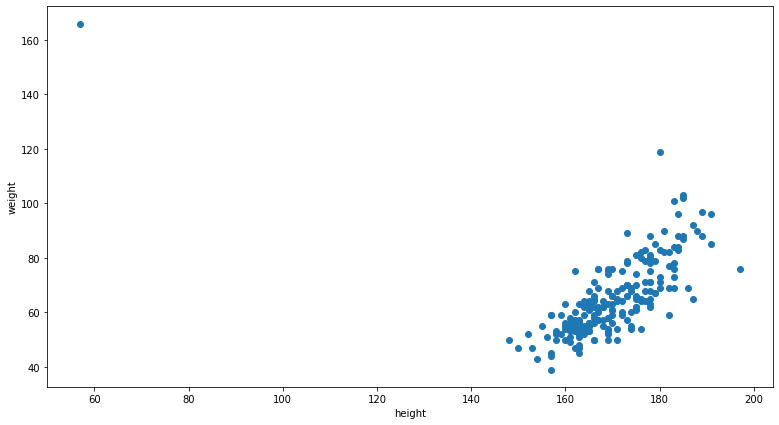

In [4]:
plt.scatter(x=davis_df["height"], y=davis_df["weight"])
plt.xlabel("height")
plt.ylabel("weight")

Text(0, 0.5, 'repwt')

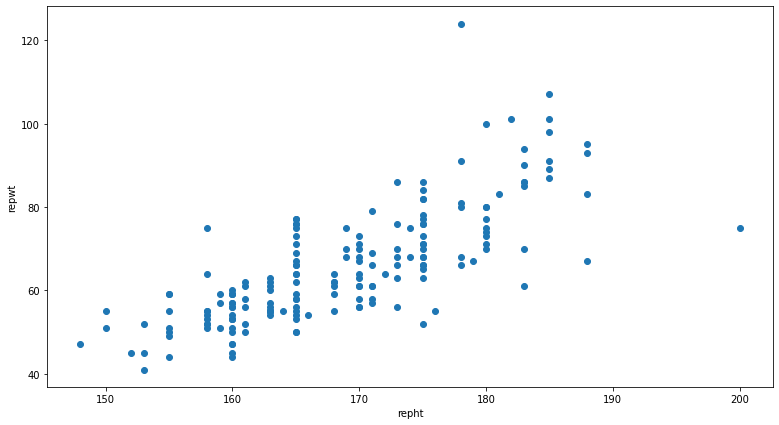

In [5]:
plt.scatter(x=davis_df["repht"], y=davis_df["repwt"])
plt.xlabel("repht")
plt.ylabel("repwt")

Text(0, 0.5, 'weight')

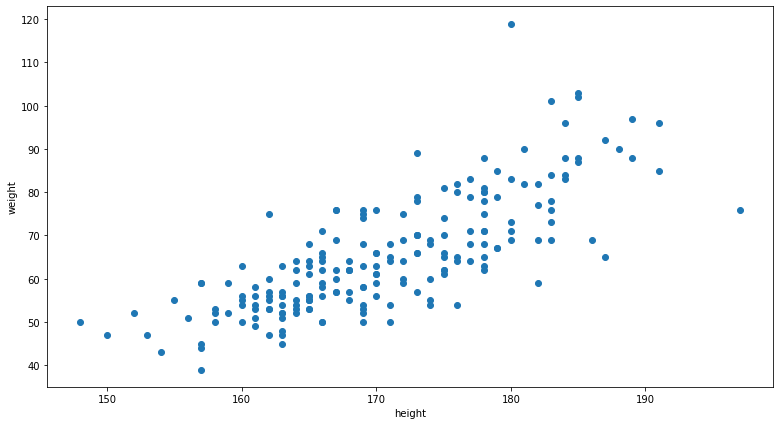

In [6]:
davis_df.where(davis_df["height"] > 100, inplace=True)
plt.scatter(x=davis_df["height"], y=davis_df["weight"])
plt.xlabel("height")
plt.ylabel("weight")

## Разбиение выборки на 2 с сохранением пропорции:

In [7]:
male_proportion(davis_df)

0.44

In [8]:
male_davis_df = davis_df[davis_df.sex == "M"]
female_davis_df = davis_df[davis_df.sex == "F"]
train_davis_df = male_davis_df.sample(frac=0.5).append(female_davis_df.sample(frac=0.5))
test_davis_df = pd.concat([davis_df, train_davis_df]).drop_duplicates(keep=False)
male_proportion(train_davis_df), male_proportion(test_davis_df)

(0.44, 0.44)

## Отображение train-выборки на в виде точек на графике

Text(0, 0.5, 'weight')

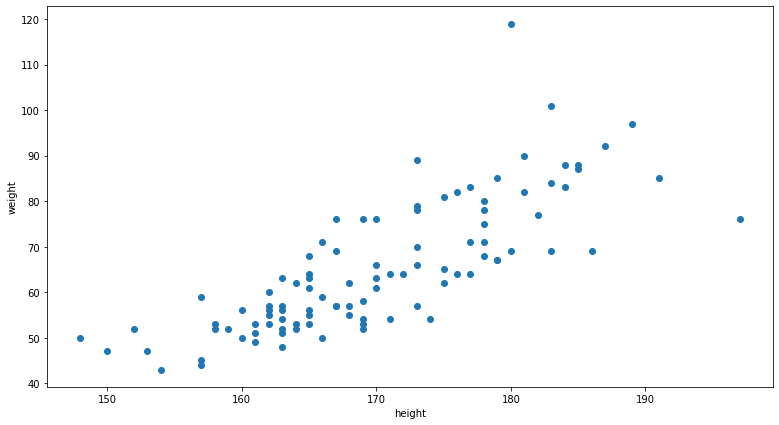

In [9]:
plt.scatter(x=train_davis_df["height"], y=train_davis_df["weight"])
plt.xlabel("height")
plt.ylabel("weight")

## Построение гистограмм роста и веса

### Общая

Text(0.5, 0, 'weight')

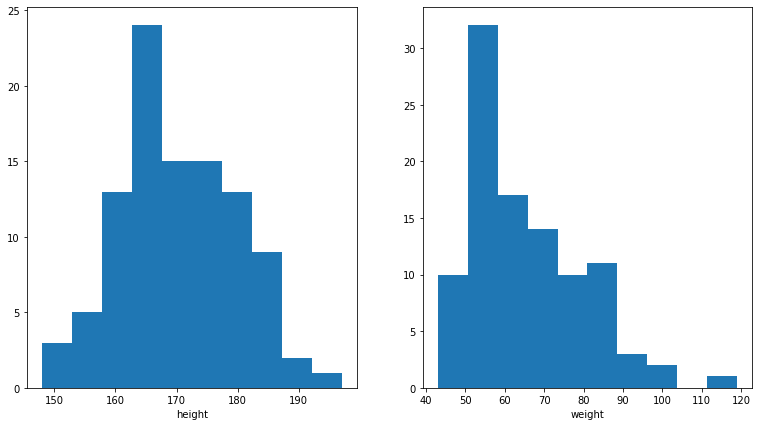

In [10]:
fig, ax = plt.subplots(ncols=2)
ax[0].hist(train_davis_df["height"])
ax[0].set_xlabel("height")
ax[1].hist(train_davis_df["weight"])
ax[1].set_xlabel("weight")

### Только мужчины

Text(0.5, 0, 'weight')

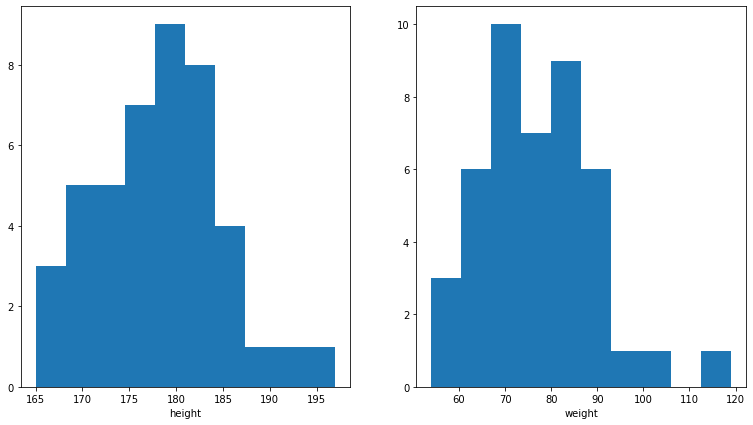

In [11]:
fig, ax = plt.subplots(ncols=2)
ax[0].hist(train_davis_df.where(train_davis_df["sex"]=="M")["height"])
ax[0].set_xlabel("height")
ax[1].hist(train_davis_df.where(train_davis_df["sex"]=="M")["weight"])
ax[1].set_xlabel("weight")

### Только женщины

Text(0.5, 0, 'weight')

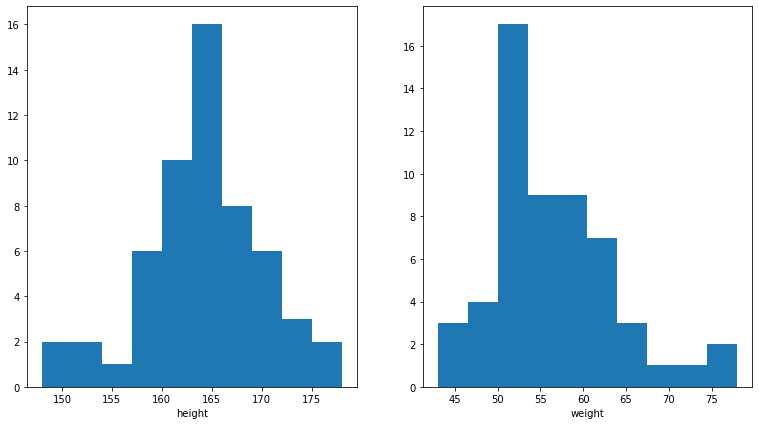

In [12]:
fig, ax = plt.subplots(ncols=2)
ax[0].hist(train_davis_df.where(train_davis_df["sex"]=="F")["height"])
ax[0].set_xlabel("height")
ax[1].hist(train_davis_df.where(train_davis_df["sex"]=="F")["weight"])
ax[1].set_xlabel("weight")

## Построение гистограмм величин (repwt - weight) и (repht - height)

### Общая

Text(0.5, 0, 'repht - height')

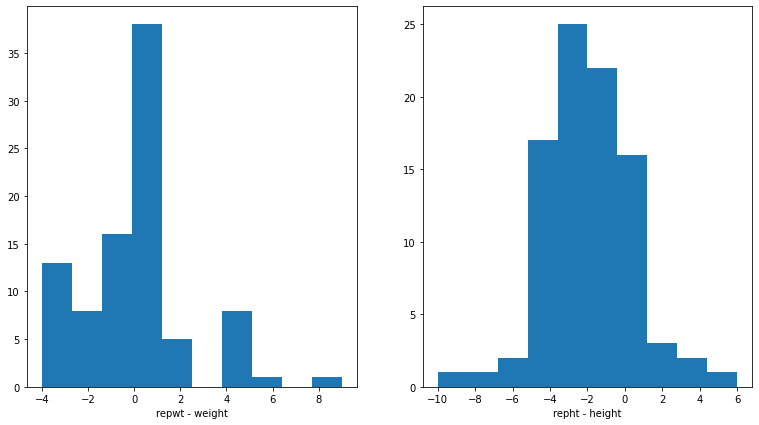

In [13]:
fig, ax = plt.subplots(ncols=2)
ax[0].hist(train_davis_df["repwt"] - train_davis_df["weight"])
ax[0].set_xlabel("repwt - weight")
ax[1].hist(train_davis_df["repht"] - train_davis_df["height"])
ax[1].set_xlabel("repht - height")

### Только мужчины

Text(0.5, 0, 'repht - height')

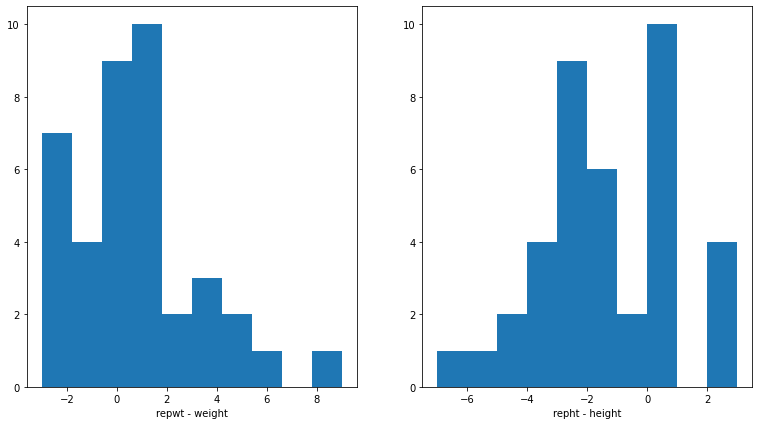

In [14]:
fig, ax = plt.subplots(ncols=2)
ax[0].hist(train_davis_df.where(train_davis_df["sex"]=="M")["repwt"] - train_davis_df.where(train_davis_df["sex"]=="M")["weight"])
ax[0].set_xlabel("repwt - weight")
ax[1].hist(train_davis_df.where(train_davis_df["sex"]=="M")["repht"] - train_davis_df.where(train_davis_df["sex"]=="M")["height"])
ax[1].set_xlabel("repht - height")

### Только женщины

Text(0.5, 0, 'repht - height')

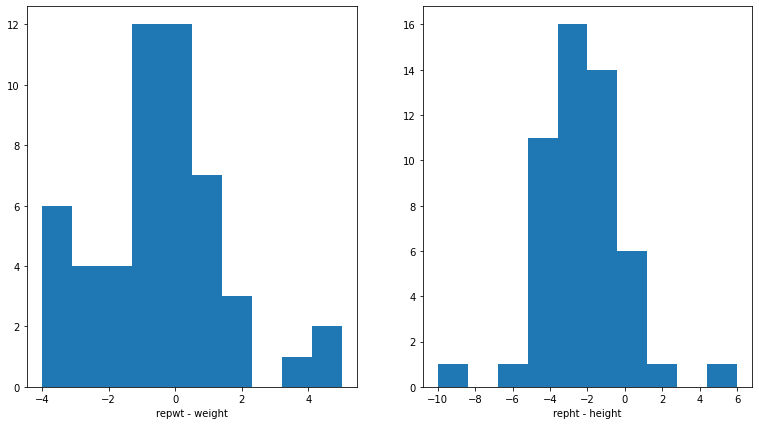

In [15]:
fig, ax = plt.subplots(ncols=2)
ax[0].hist(train_davis_df.where(train_davis_df["sex"]=="F")["repwt"] - train_davis_df.where(train_davis_df["sex"]=="F")["weight"])
ax[0].set_xlabel("repwt - weight")
ax[1].hist(train_davis_df.where(train_davis_df["sex"]=="F")["repht"] - train_davis_df.where(train_davis_df["sex"]=="F")["height"])
ax[1].set_xlabel("repht - height")

## Построение генератора

In [16]:
class DataGenerator:
    def __init__(self):
        self.p_woman = None
        self.p_man = None
        self.mean_height = { "woman": None, "man": None }
        self.mean_weight = { "woman": None, "man": None }
         
        
    def fit(self, df):
        self.p_man = male_proportion(df) 
        self.p_woman = 1 - self.p_man
        self.mean_height["woman"] = self.sex_mean_height(train_davis_df, "F")
        self.mean_height["man"] = self.sex_mean_height(train_davis_df, "M")
        self.mean_weight["woman"] = self.sex_mean_weight(train_davis_df, "F")
        self.mean_weight["man"] = self.sex_mean_weight(train_davis_df, "M")
    
    
    def choose_sex(self, N):
        arr = np.random.choice(a=[0,1], size=N, p=[self.p_woman, self.p_man])
        return arr
    
    
    def sex_mean_height(self, df, sex):
        return np.mean(train_davis_df.where(train_davis_df["sex"]== sex)["height"])
    
    
    def sex_mean_weight(self, df, sex):
        return np.mean(train_davis_df.where(train_davis_df["sex"]== sex)["weight"])
    
    

# Задание 2

## Обучение линейной модели градиентным спуском

### Улучшение параметров (w1, b)

In [17]:
def param_upgrade(df, w1, b, alpha):
    N = len(df.index)
    dQ_dw1 = 0
    dQ_db = 0
    x = df["height"].to_numpy()
    y = df["weight"].to_numpy()
    
    
    for i in range(N):
        dQ_dw1 += (-2 * x[i] * (y[i] - w1 * x[i] - b) / N)
        dQ_db += (-2 * (y[i] - w1 * x[i] - b) / N )
        
        
    w1 = w1 - alpha * dQ_dw1
    b = b - alpha * dQ_db
    return w1, b

In [18]:
param_upgrade(train_davis_df, 0, 0, 0.001)

(22.37564, 0.13036000000000003)

### Подсчет среднеквадратической ошибки

In [79]:
def squared_error_loss(df, w1, b):
    N = len(df.index)
    error = 0
    x = df["height"].to_numpy()
    y = df["weight"].to_numpy()
    for i in range(N):
        error += (y[i] - w1 * x[i] - b) ** 2 / N
    return error    

### Градиентный спуск

In [80]:
def gradient_descent(df, epoches_N, alpha):   
    w1 = 0
    b = 0
    w1_history = []
    b_history = []
    loss_history = []
    for i in tqdm(range(epoches_N)):
        w1, b = param_upgrade(df, w1, b, alpha)
        w1_history.append(w1)
        b_history.append(b)
        print(f"Loss in {i + 1} epoch:" + str(squared_error_loss(df, w1, b)))
        loss_history.append(squared_error_loss(df, w1, b))
    return w1, b, w1_history, b_history, loss_history        

In [81]:
w1, b, w1_history, b_history, loss_history = gradient_descent(train_davis_df, 1000, 1e-3)

  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]<ipython-input-79-f99fd88b60d9>:7: RuntimeWarning: overflow encountered in double_scalars
  error += (y[i] - w1 * x[i] - b) ** 2 / N
 10%|████████                                                                     | 105/1000 [00:00<00:00, 1039.95it/s]

Loss in 1 epoch:14021376.327328706
Loss in 2 epoch:45540398480.50473
Loss in 3 epoch:147913274166941.22
Loss in 4 epoch:4.80416014550642e+17
Loss in 5 epoch:1.5603707533134644e+21
Loss in 6 epoch:5.068017747229727e+24
Loss in 7 epoch:1.6460705785271547e+28
Loss in 8 epoch:5.346367129384686e+31
Loss in 9 epoch:1.736477272301451e+35
Loss in 10 epoch:5.640004220148878e+38
Loss in 11 epoch:1.8318493487184008e+42
Loss in 12 epoch:5.94976866225013e+45
Loss in 13 epoch:1.9324595201597852e+49
Loss in 14 epoch:6.276546213889054e+52
Loss in 15 epoch:2.038595477116526e+56
Loss in 16 epoch:6.62127128152682e+59
Loss in 17 epoch:2.150560710827374e+63
Loss in 18 epoch:6.98492959178054e+66
Loss in 19 epoch:2.2686753810991493e+70
Loss in 20 epoch:7.368561010066473e+73
Loss in 21 epoch:2.393277231790043e+77
Loss in 22 epoch:7.773262514050806e+80
Loss in 23 epoch:2.524722556573775e+84
Loss in 24 epoch:8.200191330410441e+87
Loss in 25 epoch:2.66338721774611e+91
Loss in 26 epoch:8.65056824387328e+94
Loss i

<ipython-input-17-807c16274594>:10: RuntimeWarning: overflow encountered in double_scalars
  dQ_dw1 += (-2 * x[i] * (y[i] - w1 * x[i] - b) / N)
<ipython-input-17-807c16274594>:14: RuntimeWarning: invalid value encountered in double_scalars
  w1 = w1 - alpha * dQ_dw1
 31%|███████████████████████▊                                                     | 310/1000 [00:00<00:00, 1030.49it/s]


Loss in 171 epoch:inf
Loss in 172 epoch:inf
Loss in 173 epoch:inf
Loss in 174 epoch:inf
Loss in 175 epoch:inf
Loss in 176 epoch:nan
Loss in 177 epoch:nan
Loss in 178 epoch:nan
Loss in 179 epoch:nan
Loss in 180 epoch:nan
Loss in 181 epoch:nan
Loss in 182 epoch:nan
Loss in 183 epoch:nan
Loss in 184 epoch:nan
Loss in 185 epoch:nan
Loss in 186 epoch:nan
Loss in 187 epoch:nan
Loss in 188 epoch:nan
Loss in 189 epoch:nan
Loss in 190 epoch:nan
Loss in 191 epoch:nan
Loss in 192 epoch:nan
Loss in 193 epoch:nan
Loss in 194 epoch:nan
Loss in 195 epoch:nan
Loss in 196 epoch:nan
Loss in 197 epoch:nan
Loss in 198 epoch:nan
Loss in 199 epoch:nan
Loss in 200 epoch:nan
Loss in 201 epoch:nan
Loss in 202 epoch:nan
Loss in 203 epoch:nan
Loss in 204 epoch:nan
Loss in 205 epoch:nan
Loss in 206 epoch:nan
Loss in 207 epoch:nan
Loss in 208 epoch:nan
Loss in 209 epoch:nan
Loss in 210 epoch:nan
Loss in 211 epoch:nan
Loss in 212 epoch:nan
Loss in 213 epoch:nan
Loss in 214 epoch:nan
Loss in 215 epoch:nan
Loss in 2

 57%|███████████████████████████████████████████▊                                 | 569/1000 [00:00<00:00, 1143.33it/s]


Loss in 423 epoch:nan
Loss in 424 epoch:nan
Loss in 425 epoch:nan
Loss in 426 epoch:nan
Loss in 427 epoch:nan
Loss in 428 epoch:nan
Loss in 429 epoch:nan
Loss in 430 epoch:nan
Loss in 431 epoch:nan
Loss in 432 epoch:nan
Loss in 433 epoch:nan
Loss in 434 epoch:nan
Loss in 435 epoch:nan
Loss in 436 epoch:nan
Loss in 437 epoch:nan
Loss in 438 epoch:nan
Loss in 439 epoch:nan
Loss in 440 epoch:nan
Loss in 441 epoch:nan
Loss in 442 epoch:nan
Loss in 443 epoch:nan
Loss in 444 epoch:nan
Loss in 445 epoch:nan
Loss in 446 epoch:nan
Loss in 447 epoch:nan
Loss in 448 epoch:nan
Loss in 449 epoch:nan
Loss in 450 epoch:nan
Loss in 451 epoch:nan
Loss in 452 epoch:nan
Loss in 453 epoch:nan
Loss in 454 epoch:nan
Loss in 455 epoch:nan
Loss in 456 epoch:nan
Loss in 457 epoch:nan
Loss in 458 epoch:nan
Loss in 459 epoch:nan
Loss in 460 epoch:nan
Loss in 461 epoch:nan
Loss in 462 epoch:nan
Loss in 463 epoch:nan
Loss in 464 epoch:nan
Loss in 465 epoch:nan
Loss in 466 epoch:nan
Loss in 467 epoch:nan
Loss in 4

 82%|███████████████████████████████████████████████████████████████▍             | 824/1000 [00:00<00:00, 1198.03it/s]


Loss in 661 epoch:nan
Loss in 662 epoch:nan
Loss in 663 epoch:nan
Loss in 664 epoch:nan
Loss in 665 epoch:nan
Loss in 666 epoch:nan
Loss in 667 epoch:nan
Loss in 668 epoch:nan
Loss in 669 epoch:nan
Loss in 670 epoch:nan
Loss in 671 epoch:nan
Loss in 672 epoch:nan
Loss in 673 epoch:nan
Loss in 674 epoch:nan
Loss in 675 epoch:nan
Loss in 676 epoch:nan
Loss in 677 epoch:nan
Loss in 678 epoch:nan
Loss in 679 epoch:nan
Loss in 680 epoch:nan
Loss in 681 epoch:nan
Loss in 682 epoch:nan
Loss in 683 epoch:nan
Loss in 684 epoch:nan
Loss in 685 epoch:nan
Loss in 686 epoch:nan
Loss in 687 epoch:nan
Loss in 688 epoch:nan
Loss in 689 epoch:nan
Loss in 690 epoch:nan
Loss in 691 epoch:nan
Loss in 692 epoch:nan
Loss in 693 epoch:nan
Loss in 694 epoch:nan
Loss in 695 epoch:nan
Loss in 696 epoch:nan
Loss in 697 epoch:nan
Loss in 698 epoch:nan
Loss in 699 epoch:nan
Loss in 700 epoch:nan
Loss in 701 epoch:nan
Loss in 702 epoch:nan
Loss in 703 epoch:nan
Loss in 704 epoch:nan
Loss in 705 epoch:nan
Loss in 7

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1174.65it/s]


Loss in 895 epoch:nan
Loss in 896 epoch:nan
Loss in 897 epoch:nan
Loss in 898 epoch:nan
Loss in 899 epoch:nan
Loss in 900 epoch:nan
Loss in 901 epoch:nan
Loss in 902 epoch:nan
Loss in 903 epoch:nan
Loss in 904 epoch:nan
Loss in 905 epoch:nan
Loss in 906 epoch:nan
Loss in 907 epoch:nan
Loss in 908 epoch:nan
Loss in 909 epoch:nan
Loss in 910 epoch:nan
Loss in 911 epoch:nan
Loss in 912 epoch:nan
Loss in 913 epoch:nan
Loss in 914 epoch:nan
Loss in 915 epoch:nan
Loss in 916 epoch:nan
Loss in 917 epoch:nan
Loss in 918 epoch:nan
Loss in 919 epoch:nan
Loss in 920 epoch:nan
Loss in 921 epoch:nan
Loss in 922 epoch:nan
Loss in 923 epoch:nan
Loss in 924 epoch:nan
Loss in 925 epoch:nan
Loss in 926 epoch:nan
Loss in 927 epoch:nan
Loss in 928 epoch:nan
Loss in 929 epoch:nan
Loss in 930 epoch:nan
Loss in 931 epoch:nan
Loss in 932 epoch:nan
Loss in 933 epoch:nan
Loss in 934 epoch:nan
Loss in 935 epoch:nan
Loss in 936 epoch:nan
Loss in 937 epoch:nan
Loss in 938 epoch:nan
Loss in 939 epoch:nan
Loss in 9

In [82]:
w1, b

(nan, nan)

In [83]:
w1_history

[22.37564,
 -1252.8309003776003,
 71422.2787922303,
 -4070394.2665772717,
 231975266.6104343,
 -13220468463.928047,
 753445784374.3273,
 -42939518484023.58,
 2447159816776866.0,
 -1.3946572715004928e+17,
 7.948270855113313e+18,
 -4.529787416393316e+20,
 2.5815645203528633e+22,
 -1.4712556595097493e+24,
 8.384811607743968e+25,
 -4.7785757181579785e+27,
 2.723351097486735e+29,
 -1.5520610402802477e+31,
 8.845328371280773e+32,
 -5.041028153226317e+34,
 2.872924980843958e+36,
 -1.6373044733493103e+38,
 9.331137973752987e+39,
 -5.317895193134242e+41,
 3.0307138705597854e+43,
 -1.727229708675382e+45,
 9.843629566983218e+46,
 -5.6099685273649485e+48,
 3.1971689572295034e+50,
 -1.822093883630628e+52,
 1.0384268598807812e+54,
 -5.918083327151198e+55,
 3.3727662120686996e+57,
 -1.9221682582742773e+59,
 1.0954601003462345e+61,
 -6.243120633611812e+62,
 3.558007747932627e+64,
 -2.027738991009179e+66,
 1.1556257622114605e+68,
 -6.586009877051153e+69,
 3.753423255086479e+71,
 -2.139107956839549e+73,

In [84]:
b_history

[0.13036000000000003,
 -7.347705832800001,
 418.7849123252575,
 -23866.925532433535,
 1360196.3972002356,
 -77518754.01811402,
 4417859970.725098,
 -251777611352.04474,
 14349021018808.48,
 -817762957923699.4,
 4.660500911355188e+16,
 -2.656059257060304e+18,
 1.5137108459365935e+20,
 -8.626767339679334e+21,
 4.9164683554150494e+23,
 -2.801937288678061e+25,
 1.5968479815470696e+27,
 -9.100572973116002e+28,
 5.186494230889201e+30,
 -2.955827340378615e+32,
 1.6845512358030338e+34,
 -9.600401306532483e+35,
 5.47135066524313e+37,
 -3.1181694541963636e+39,
 1.7770713924166255e+41,
 -1.0127681577714205e+43,
 5.771852193292445e+44,
 -3.2894278404765743e+46,
 1.874673008826674e+48,
 -1.068392152209086e+50,
 6.088858086330394e+51,
 -3.4700922052650547e+53,
 1.977635172689405e+55,
 -1.1270711684041596e+57,
 6.423274809177463e+58,
 -3.660679150601672e+60,
 2.0862522999176833e+62,
 -1.1889729964988734e+64,
 6.776058612178828e+65,
 -3.8617336517218617e+67,
 2.2008349765507478e+69,
 -1.25427464212852

### Нормализируем данные

In [85]:
def normalize(df):
    df = df.copy()
    df["height"] = (df["height"] - df["height"].mean()) / df["height"].std()
    df["weight"] = (df["weight"] - df["weight"].mean()) / df["weight"].std() 
    return df 
normalize(train_davis_df)

,Unnamed: 0,sex,weight,height,repwt,repht
190,191.0,M,1.596110,1.563246,93.0,188.0
60,61.0,M,0.197241,-0.522472,69.0,165.0
170,171.0,M,0.756788,-0.105329,75.0,165.0
31,32.0,M,0.686845,0.833244,73.0,175.0
7,8.0,M,0.267184,1.667531,73.0,180.0
...,...,...,...,...,...,...
136,137.0,F,-0.082533,0.207529,62.0,168.0
47,48.0,F,-1.131685,-0.939616,NaN,NaN
152,153.0,F,-1.271572,-2.086761,45.0,152.0
65,66.0,F,-0.362307,-0.835330,59.0,160.0


In [90]:
w1, b, w1_history, b_history, loss_history = gradient_descent(normalize(train_davis_df), 1000, 0.001)

 11%|████████▍                                                                    | 110/1000 [00:00<00:00, 1099.51it/s]

Loss in 1 epoch:0.9875854820970217
Loss in 2 epoch:0.9851805162190646
Loss in 3 epoch:0.9827850645775551
Loss in 4 epoch:0.980399089533417
Loss in 5 epoch:0.9780225535964776
Loss in 6 epoch:0.975655419424877
Loss in 7 epoch:0.9732976498244834
Loss in 8 epoch:0.9709492077483071
Loss in 9 epoch:0.9686100562959201
Loss in 10 epoch:0.9662801587128749
Loss in 11 epoch:0.9639594783901286
Loss in 12 epoch:0.9616479788634646
Loss in 13 epoch:0.959345623812924
Loss in 14 epoch:0.9570523770622308
Loss in 15 epoch:0.9547682025782259
Loss in 16 epoch:0.9524930644702994
Loss in 17 epoch:0.9502269269898292
Loss in 18 epoch:0.9479697545296165
Loss in 19 epoch:0.9457215116233272
Loss in 20 epoch:0.9434821629449353
Loss in 21 epoch:0.9412516733081673
Loss in 22 epoch:0.9390300076659495
Loss in 23 epoch:0.9368171311098562
Loss in 24 epoch:0.9346130088695646
Loss in 25 epoch:0.932417606312303
Loss in 26 epoch:0.9302308889423128
Loss in 27 epoch:0.9280528224003003
Loss in 28 epoch:0.9258833724629022
Loss 

 34%|█████████████████████████▉                                                   | 337/1000 [00:00<00:00, 1107.05it/s]


Loss in 218 epoch:0.6368720167622786
Loss in 219 epoch:0.6358545012699769
Loss in 220 epoch:0.6348410111499567
Loss in 221 epoch:0.6338315304775249
Loss in 222 epoch:0.632826043390988
Loss in 223 epoch:0.631824534091403
Loss in 224 epoch:0.6308269868423265
Loss in 225 epoch:0.6298333859695724
Loss in 226 epoch:0.6288437158609615
Loss in 227 epoch:0.6278579609660779
Loss in 228 epoch:0.6268761057960245
Loss in 229 epoch:0.6258981349231804
Loss in 230 epoch:0.6249240329809547
Loss in 231 epoch:0.6239537846635513
Loss in 232 epoch:0.6229873747257232
Loss in 233 epoch:0.6220247879825358
Loss in 234 epoch:0.6210660093091256
Loss in 235 epoch:0.6201110236404666
Loss in 236 epoch:0.6191598159711297
Loss in 237 epoch:0.6182123713550486
Loss in 238 epoch:0.6172686749052856
Loss in 239 epoch:0.6163287117937964
Loss in 240 epoch:0.615392467251197
Loss in 241 epoch:0.6144599265665327
Loss in 242 epoch:0.6135310750870481
Loss in 243 epoch:0.6126058982179521
Loss in 244 epoch:0.6116843814221947
Los

 57%|███████████████████████████████████████████▋                                 | 568/1000 [00:00<00:00, 1124.22it/s]


Loss in 440 epoch:0.4863533422690344
Loss in 441 epoch:0.48593129063431467
Loss in 442 epoch:0.4855109086694567
Loss in 443 epoch:0.4850921897691142
Loss in 444 epoch:0.48467512735407137
Loss in 445 epoch:0.4842597148711408
Loss in 446 epoch:0.4838459457930595
Loss in 447 epoch:0.48343381361838705
Loss in 448 epoch:0.4830233118714036
Loss in 449 epoch:0.4826144341020069
Loss in 450 epoch:0.4822071738856129
Loss in 451 epoch:0.4818015248230524
Loss in 452 epoch:0.4813974805404733
Loss in 453 epoch:0.480995034689238
Loss in 454 epoch:0.48059418094582484
Loss in 455 epoch:0.48019491301172856
Loss in 456 epoch:0.4797972246133611
Loss in 457 epoch:0.4794011095019543
Loss in 458 epoch:0.4790065614534588
Loss in 459 epoch:0.47861357426844864
Loss in 460 epoch:0.4782221417720245
Loss in 461 epoch:0.47783225781371425
Loss in 462 epoch:0.47744391626737737
Loss in 463 epoch:0.47705711103110987
Loss in 464 epoch:0.4766718360271474
Loss in 465 epoch:0.4762880852017681
Loss in 466 epoch:0.475905852

 79%|████████████████████████████████████████████████████████████▋                | 788/1000 [00:00<00:00, 1104.74it/s]


Loss in 640 epoch:0.4279524869098921
Loss in 641 epoch:0.4277614737076806
Loss in 642 epoch:0.42757121616890204
Loss in 643 epoch:0.42738171130409136
Loss in 644 epoch:0.42719295613561037
Loss in 645 epoch:0.427004947697601
Loss in 646 epoch:0.42681768303593803
Loss in 647 epoch:0.4266311592081822
Loss in 648 epoch:0.42644537328353666
Loss in 649 epoch:0.4262603223427975
Loss in 650 epoch:0.4260760034783099
Loss in 651 epoch:0.4258924137939221
Loss in 652 epoch:0.42570955040493963
Loss in 653 epoch:0.42552741043807985
Loss in 654 epoch:0.4253459910314269
Loss in 655 epoch:0.425165289334388
Loss in 656 epoch:0.4249853025076465
Loss in 657 epoch:0.4248060277231182
Loss in 658 epoch:0.4246274621639084
Loss in 659 epoch:0.4244496030242639
Loss in 660 epoch:0.42427244750953386
Loss in 661 epoch:0.4240959928361218
Loss in 662 epoch:0.42392023623144304
Loss in 663 epoch:0.4237451749338829
Loss in 664 epoch:0.42357080619275106
Loss in 665 epoch:0.42339712726823886
Loss in 666 epoch:0.42322413

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1116.84it/s]


Loss in 846 epoch:0.4010076868419752
Loss in 847 epoch:0.4009232694136387
Loss in 848 epoch:0.4008391859473683
Loss in 849 epoch:0.40075543512198364
Loss in 850 epoch:0.40067201562153065
Loss in 851 epoch:0.4005889261352617
Loss in 852 epoch:0.40050616535761435
Loss in 853 epoch:0.40042373198819103
Loss in 854 epoch:0.40034162473173907
Loss in 855 epoch:0.4002598422981293
Loss in 856 epoch:0.40017838340233675
Loss in 857 epoch:0.4000972467644201
Loss in 858 epoch:0.4000164311095016
Loss in 859 epoch:0.39993593516774656
Loss in 860 epoch:0.39985575767434467
Loss in 861 epoch:0.39977589736948876
Loss in 862 epoch:0.39969635299835615
Loss in 863 epoch:0.3996171233110872
Loss in 864 epoch:0.39953820706276777
Loss in 865 epoch:0.39945960301340844
Loss in 866 epoch:0.3993813099279251
Loss in 867 epoch:0.39930332657612033
Loss in 868 epoch:0.3992256517326627
Loss in 869 epoch:0.39914828417706855
Loss in 870 epoch:0.39907122269368295
Loss in 871 epoch:0.3989944660716597
Loss in 872 epoch:0.39

In [91]:
w1, b

(0.6769769470798604, -8.489754038665267e-16)

In [92]:
w1_history

[0.001554641645047439,
 0.0031062050996376834,
 0.0046546964585878385,
 0.006200121804647273,
 0.007742487208521509,
 0.009281798728896075,
 0.010818062412460298,
 0.012351284293931066,
 0.01388147039607652,
 0.015408626729739727,
 0.01693275929386228,
 0.018453874075507873,
 0.019971977049885806,
 0.02148707418037447,
 0.022999171418544767,
 0.024508274704183486,
 0.02601438996531664,
 0.027517523118232752,
 0.029017680067506088,
 0.030514866706019862,
 0.03200908891498938,
 0.03350035256398514,
 0.034988663510955885,
 0.03647402760225163,
 0.03795645067264661,
 0.039435938545362204,
 0.04091249703208982,
 0.04238613193301372,
 0.043856849036833796,
 0.0453246541207883,
 0.04678955295067658,
 0.048251551280881676,
 0.049710654854392966,
 0.051166869402828705,
 0.052620200646458545,
 0.054070654294225994,
 0.05551823604377086,
 0.056962951581451635,
 0.058404806582367796,
 0.05984380671038215,
 0.06127995761814303,
 0.06271326494710655,
 0.06414373432755872,
 0.0655713713786376,
 0.066

In [93]:
b_history

[-8.014422459012849e-19,
 -1.3426759704060487e-18,
 -2.3279989047608753e-18,
 -3.0912772341906703e-18,
 -4.132111319776755e-18,
 -5.0653925498522766e-18,
 -5.984795992119985e-18,
 -7.029099524658023e-18,
 -8.316264343832814e-18,
 -9.6936347837584e-18,
 -1.0599160438218293e-17,
 -1.1324274851176599e-17,
 -1.2219392164780632e-17,
 -1.2941037130786984e-17,
 -1.3902073936478134e-17,
 -1.4970663597679847e-17,
 -1.5924761509467092e-17,
 -1.7024576193236388e-17,
 -1.8308271565459226e-17,
 -1.928318615895819e-17,
 -2.0240753517697387e-17,
 -2.1125462490445558e-17,
 -2.2332830029725415e-17,
 -2.3214069555521635e-17,
 -2.3925306180672126e-17,
 -2.4945323584546487e-17,
 -2.5750235277399727e-17,
 -2.680147770384167e-17,
 -2.804007026568911e-17,
 -2.924743780496897e-17,
 -3.02778635496992e-17,
 -3.1318697635285285e-17,
 -3.2317898357447927e-17,
 -3.3278935163139075e-17,
 -3.431976924872516e-17,
 -3.5482033977629626e-17,
 -3.678307658461223e-17,
 -3.776146062506315e-17,
 -3.867392517342695e-17,
 -3.

In [96]:
loss_history

[0.9875854820970217,
 0.9851805162190646,
 0.9827850645775551,
 0.980399089533417,
 0.9780225535964776,
 0.975655419424877,
 0.9732976498244834,
 0.9709492077483071,
 0.9686100562959201,
 0.9662801587128749,
 0.9639594783901286,
 0.9616479788634646,
 0.959345623812924,
 0.9570523770622308,
 0.9547682025782259,
 0.9524930644702994,
 0.9502269269898292,
 0.9479697545296165,
 0.9457215116233272,
 0.9434821629449353,
 0.9412516733081673,
 0.9390300076659495,
 0.9368171311098562,
 0.9346130088695646,
 0.932417606312303,
 0.9302308889423128,
 0.9280528224003003,
 0.9258833724629022,
 0.9237225050421441,
 0.9215701861849092,
 0.9194263820723966,
 0.9172910590196011,
 0.9151641834747734,
 0.9130457220189001,
 0.9109356413651761,
 0.9088339083584811,
 0.9067404899748575,
 0.9046553533209967,
 0.9025784656337154,
 0.9005097942794447,
 0.8984493067537174,
 0.8963969706806572,
 0.8943527538124678,
 0.8923166240289285,
 0.8902885493368895,
 0.8882684978697659,
 0.8862564378870432,
 0.88425233777377

### Визуализация

In [106]:
B = b_history
W1 = w1_history
X = train_davis_df["height"].to_numpy()
Y = train_davis_df["weight"].to_numpy()
N = len(train_davis_df.index)
Z = np.array(shape=(100 * 100), 1)
epoches_N = len(b_history)
for i in range(N):
    for j in range(epoches_N):
        Z[i][j].append(((Y[i] - W1[j] * X[i] - B[j])) ** 2 / N)
contour = plt.contour(B, W1, Z)    

SyntaxError: positional argument follows keyword argument (<ipython-input-106-ed8c1fc78dca>, line 6)